In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D
import os
import cv2
import pickle
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext tensorboard

In [2]:
dataPath = "../../data/OCT/OCT2017/"

In [3]:
labels_available = os.listdir(os.path.join(dataPath, "train"))
print("Total Number of Classes Detected :",len(labels_available))

labels_list = ['NORMAL',"CNV","DME","DRUSEN"]

Total Number of Classes Detected : 4


In [4]:
images=[]
y_trn=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "train", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        images.append(cv2.imread(os.path.join(xPath, y)))
        y_trn.append(labels_list.index(x))
    print(x ,end=" ")

y_train = to_categorical(y_trn,len(labels_list))

NORMAL CNV DME DRUSEN 

In [5]:
x_val=[]
y_val=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "val", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_val.append(cv2.imread(os.path.join(xPath, y)))
        y_val.append(labels_list.index(x))
    print(x ,end=" ")

y_validation = to_categorical(y_val,len(labels_list))

NORMAL CNV DME DRUSEN 

In [6]:
x_tst=[]
y_tst=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "test", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_tst.append(cv2.imread(os.path.join(xPath, y)))
        y_tst.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [65]:
def resizeIm(im, size):
    if im.shape[2] == 1:
        im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    return cv2.resize(im, size)

def resizeIms(x, size):
    return np.array(list(map(lambda im: resizeIm(im, size), x)))

In [66]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction, model):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];
        self.logPath = os.path.join(model, "log.txt")

        if not os.path.isdir(model):
            os.mkdir(model)

        with open(self.logPath,'w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open(self.logPath,'a') as f:
              f.write('End of logging..\n')
    
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

## Load models

In [67]:
# xception base model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
xceptionNetModel = Xception(weights='imagenet')

# opticnet base model
opticNetModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')

# resnet base model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resNetModel = ResNet50(weights='imagenet')

In [68]:
def emptyModelGenerator(model):
    model = model.lower()
    if model == "resnet":
        x = resNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=resNetModel.input, outputs=predictions)
        size = (224, 224)
    elif model == "xception":
        x = xceptionNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=xceptionNetModel.input, outputs=predictions)
        size = (299, 299)
    elif model == "opticnet":
        newModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')
        size = (224, 224)
    return newModel, size


def testPredict(model, size, name=None):
    X_test = resizeIms(x_tst, size)
    X_test = np.array(X_test)
    Y_test = np.array(y_tst)
    
    prediction = model.predict(X_test)
    preds = np.argmax(prediction, axis=1)
    acc = sum(preds == Y_test) / len(Y_test)
    print(f'Test acc for {name if name else "model"}: {acc:.6f}')
    

def computeConfussionMatrix(predictions, labels):
    num_labels = len(labels_list)
    cMatrix = np.zeros(shape=(num_labels, num_labels))
    for i in len(predictions):
        p = int(predictions[i])
        t = int(predictions[i])
        cMatrix[t, p] += 1
    print(cMatrix)
    ax = sns.heatmap(cMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion matrix")
    plt.show();
    return cMatrix
    


In [69]:
optim = Adam(learning_rate=0.001)
epochs = 30
batch_size = 50

Labels fraction: [0.10115903 0.10044349 0.09834332 0.09668059]
Training xception for 0.1% of train size (aka 8348 images)...


<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 134s 770ms/step - loss: 1.3240 - accuracy: 0.5379 - val_loss: 1.2862 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 128s 765ms/step - loss: 1.1178 - accuracy: 0.7646 - val_loss: 1.2015 - val_accuracy: 0.6250
Epoch 3/30
167/167 [==============================] - 129s 773ms/step - loss: 0.9766 - accuracy: 0.8686 - val_loss: 1.0372 - val_accuracy: 0.5938
Epoch 4/30
167/167 [==============================] - 128s 768ms/step - loss: 0.8353 - accuracy: 0.9250 - val_loss: 0.8896 - val_accuracy: 0.9375
Epoch 5/30
167/167 [==============================] - 129s 771ms/step - loss: 0.7355 - accuracy: 0.9426 - val_loss: 0.7862 - val_accuracy: 0.9375
Epoch 6/30
167/167 [==============================] - 128s 768ms/step - loss: 0.6618 - accuracy: 0.9457 - val_loss: 0.9326 - val_accuracy: 0.8438
Epoch 7/30
167/167 [==============================] - 128s 768ms/step - loss: 0.6049 - accuracy: 0.9497 - val_loss: 0.6107 - val_accuracy: 1.0000
Epoch 8/30
167/167 [==============================] - 128s 767ms/step - loss: 0.5513 - accuracy: 0.9608 - val_loss: 0.5962 -

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 44s 225ms/step - loss: 1.2941 - accuracy: 0.6698 - val_loss: 1.4108 - val_accuracy: 0.2500


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 33s 198ms/step - loss: 1.1309 - accuracy: 0.7400 - val_loss: 1.3028 - val_accuracy: 0.5000
Epoch 3/30
167/167 [==============================] - 33s 199ms/step - loss: 1.0128 - accuracy: 0.7571 - val_loss: 1.3246 - val_accuracy: 0.4375
Epoch 4/30
167/167 [==============================] - 33s 199ms/step - loss: 0.9142 - accuracy: 0.8140 - val_loss: 1.2566 - val_accuracy: 0.5000
Epoch 5/30
167/167 [==============================] - 33s 199ms/step - loss: 0.8528 - accuracy: 0.8199 - val_loss: 1.3955 - val_accuracy: 0.4688
Epoch 6/30
167/167 [==============================] - 33s 199ms/step - loss: 0.7957 - accuracy: 0.8339 - val_loss: 1.0670 - val_accuracy: 0.6875
Epoch 7/30
167/167 [==============================] - 33s 199ms/step - loss: 0.7341 - accuracy: 0.8547 - val_loss: 1.1764 - val_accuracy: 0.5312
Epoch 8/30
167/167 [==============================] - 33s 199ms/step - loss: 0.6925 - accuracy: 0.8628 - val_loss: 1.0615 - val_ac

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 214s 1s/step - loss: 0.9220 - accuracy: 0.7687 - val_loss: 0.0500 - val_accuracy: 0.9688


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 198s 1s/step - loss: 0.1633 - accuracy: 0.9510 - val_loss: 0.0621 - val_accuracy: 0.9688
Epoch 3/30
167/167 [==============================] - 198s 1s/step - loss: 0.1080 - accuracy: 0.9648 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 4/30
167/167 [==============================] - 198s 1s/step - loss: 0.1695 - accuracy: 0.9533 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 5/30
167/167 [==============================] - 198s 1s/step - loss: 0.0701 - accuracy: 0.9772 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 6/30
167/167 [==============================] - 198s 1s/step - loss: 0.0452 - accuracy: 0.9845 - val_loss: 0.0264 - val_accuracy: 1.0000
Epoch 7/30
167/167 [==============================] - 198s 1s/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 8/30
167/167 [==============================] - 198s 1s/step - loss: 0.0237 - accuracy: 0.9912 - val_loss: 0.0044 - val_accuracy: 1.0000

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 328s 773ms/step - loss: 1.2378 - accuracy: 0.7900 - val_loss: 1.0977 - val_accuracy: 0.7188


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 319s 764ms/step - loss: 0.8100 - accuracy: 0.9285 - val_loss: 0.9220 - val_accuracy: 0.8438
Epoch 3/30
418/418 [==============================] - 319s 764ms/step - loss: 0.5949 - accuracy: 0.9402 - val_loss: 0.5664 - val_accuracy: 0.9688
Epoch 4/30
418/418 [==============================] - 319s 764ms/step - loss: 0.4805 - accuracy: 0.9414 - val_loss: 0.4835 - val_accuracy: 0.9688
Epoch 5/30
418/418 [==============================] - 319s 764ms/step - loss: 0.3890 - accuracy: 0.9519 - val_loss: 0.3696 - val_accuracy: 0.9688
Epoch 6/30
418/418 [==============================] - 319s 764ms/step - loss: 0.3426 - accuracy: 0.9455 - val_loss: 0.3289 - val_accuracy: 0.9688
Epoch 7/30
418/418 [==============================] - 319s 763ms/step - loss: 0.2959 - accuracy: 0.9570 - val_loss: 0.4213 - val_accuracy: 0.9375
Epoch 8/30
418/418 [==============================] - 320s 764ms/step - loss: 0.2596 - accuracy: 0.9620 - val_loss: 0.1950 -

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 93s 206ms/step - loss: 1.2437 - accuracy: 0.7129 - val_loss: 1.3012 - val_accuracy: 0.5000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 83s 199ms/step - loss: 0.9537 - accuracy: 0.7592 - val_loss: 1.1784 - val_accuracy: 0.5000
Epoch 3/30
418/418 [==============================] - 83s 199ms/step - loss: 0.8229 - accuracy: 0.7604 - val_loss: 1.1627 - val_accuracy: 0.5000
Epoch 4/30
418/418 [==============================] - 83s 199ms/step - loss: 0.6558 - accuracy: 0.8512 - val_loss: 0.5662 - val_accuracy: 1.0000
Epoch 5/30
418/418 [==============================] - 83s 199ms/step - loss: 0.5219 - accuracy: 0.9028 - val_loss: 0.5756 - val_accuracy: 0.9375
Epoch 6/30
418/418 [==============================] - 83s 199ms/step - loss: 0.4301 - accuracy: 0.9229 - val_loss: 0.3810 - val_accuracy: 0.9688
Epoch 7/30
418/418 [==============================] - 83s 199ms/step - loss: 0.3601 - accuracy: 0.9366 - val_loss: 0.4051 - val_accuracy: 0.9375
Epoch 8/30
418/418 [==============================] - 83s 199ms/step - loss: 0.3240 - accuracy: 0.9383 - val_loss: 0.2396 - val_ac

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 510s 1s/step - loss: 0.5570 - accuracy: 0.8513 - val_loss: 0.3989 - val_accuracy: 0.8125


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 493s 1s/step - loss: 0.1314 - accuracy: 0.9574 - val_loss: 0.0612 - val_accuracy: 1.0000
Epoch 3/30
418/418 [==============================] - 493s 1s/step - loss: 0.1113 - accuracy: 0.9641 - val_loss: 0.1124 - val_accuracy: 0.9688
Epoch 4/30
418/418 [==============================] - 493s 1s/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 0.0580 - val_accuracy: 0.9688
Epoch 5/30
418/418 [==============================] - 493s 1s/step - loss: 0.0685 - accuracy: 0.9770 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/30
418/418 [==============================] - 491s 1s/step - loss: 0.0561 - accuracy: 0.9817 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 7/30
418/418 [==============================] - 492s 1s/step - loss: 0.0404 - accuracy: 0.9879 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/30
418/418 [==============================] - 491s 1s/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0253 - val_accuracy: 0.9688

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 520s 771ms/step - loss: 1.2008 - accuracy: 0.6756 - val_loss: 1.1202 - val_accuracy: 0.5938


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 511s 765ms/step - loss: 0.7435 - accuracy: 0.8298 - val_loss: 0.7956 - val_accuracy: 0.6875
Epoch 3/30
668/668 [==============================] - 511s 764ms/step - loss: 0.5918 - accuracy: 0.8215 - val_loss: 0.6196 - val_accuracy: 0.7500
Epoch 4/30
668/668 [==============================] - 510s 764ms/step - loss: 0.5034 - accuracy: 0.8361 - val_loss: 0.5634 - val_accuracy: 0.7500
Epoch 5/30
668/668 [==============================] - 511s 765ms/step - loss: 0.4627 - accuracy: 0.8350 - val_loss: 0.4763 - val_accuracy: 0.7500
Epoch 6/30
668/668 [==============================] - 510s 764ms/step - loss: 0.3499 - accuracy: 0.9300 - val_loss: 0.2327 - val_accuracy: 1.0000
Epoch 7/30
668/668 [==============================] - 510s 764ms/step - loss: 0.2237 - accuracy: 0.9735 - val_loss: 0.1601 - val_accuracy: 1.0000
Epoch 8/30
668/668 [==============================] - 511s 765ms/step - loss: 0.1794 - accuracy: 0.9750 - val_loss: 0.1308 -

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 143s 204ms/step - loss: 1.1676 - accuracy: 0.7484 - val_loss: 0.8432 - val_accuracy: 0.9062


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 133s 199ms/step - loss: 0.6506 - accuracy: 0.9212 - val_loss: 0.5430 - val_accuracy: 0.9688
Epoch 3/30
668/668 [==============================] - 133s 199ms/step - loss: 0.4496 - accuracy: 0.9289 - val_loss: 0.3148 - val_accuracy: 1.0000
Epoch 4/30
668/668 [==============================] - 133s 199ms/step - loss: 0.3426 - accuracy: 0.9436 - val_loss: 0.4474 - val_accuracy: 0.9062
Epoch 5/30
668/668 [==============================] - 133s 199ms/step - loss: 0.2672 - accuracy: 0.9531 - val_loss: 0.1741 - val_accuracy: 1.0000
Epoch 6/30
668/668 [==============================] - 133s 199ms/step - loss: 0.2328 - accuracy: 0.9549 - val_loss: 0.1285 - val_accuracy: 1.0000
Epoch 7/30
668/668 [==============================] - 133s 199ms/step - loss: 0.1891 - accuracy: 0.9644 - val_loss: 0.1079 - val_accuracy: 1.0000
Epoch 8/30
668/668 [==============================] - 133s 199ms/step - loss: 0.1616 - accuracy: 0.9693 - val_loss: 0.0873 -

<ipython-input-66-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 803s 1s/step - loss: 0.4535 - accuracy: 0.8760 - val_loss: 0.0722 - val_accuracy: 1.0000


<ipython-input-66-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 787s 1s/step - loss: 0.1328 - accuracy: 0.9564 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 3/30
668/668 [==============================] - 786s 1s/step - loss: 0.1064 - accuracy: 0.9633 - val_loss: 0.1726 - val_accuracy: 0.9062
Epoch 4/30
668/668 [==============================] - 787s 1s/step - loss: 0.0851 - accuracy: 0.9713 - val_loss: 0.1033 - val_accuracy: 0.9688
Epoch 5/30
668/668 [==============================] - 787s 1s/step - loss: 0.0697 - accuracy: 0.9754 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 6/30
668/668 [==============================] - 786s 1s/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0434 - val_accuracy: 0.9688
Epoch 7/30
668/668 [==============================] - 786s 1s/step - loss: 0.0416 - accuracy: 0.9855 - val_loss: 0.0396 - val_accuracy: 0.9688
Epoch 8/30
668/668 [==============================] - 787s 1s/step - loss: 0.0340 - accuracy: 0.9882 - val_loss: 0.1706 - val_accuracy: 0.9688

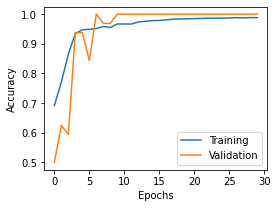

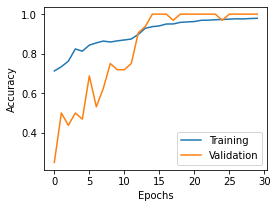

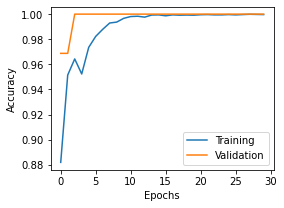

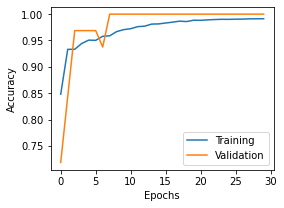

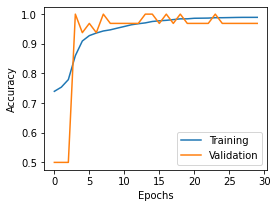

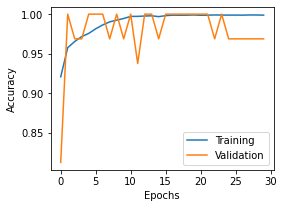

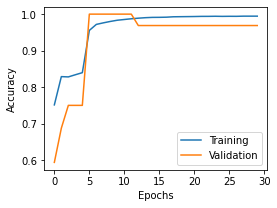

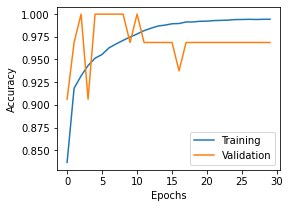

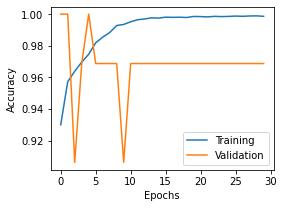

In [71]:
from sklearn.model_selection import train_test_split
import datetime

maxTrain = len(y_train)
#for p in [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]:
for p in [0.1, 0.25, 0.4]:
    #X_trn, X_tst, y_trn, y_tst
    X_t, _, y_t, _ = train_test_split(images, y_train, test_size=1-p, random_state=123)
    print(f"Labels fraction: {sum(y_t == 1) / sum(y_train == 1)}")
    for net in ["xception", "resnet", "opticnet"]:
        print(f"Training {net} for {p}% of train size (aka {len(X_t)} images)...")
        model, size = emptyModelGenerator(net)
        X_trn = resizeIms(X_t, size)
        X_val = resizeIms(x_val, size)
        log_dir = f"logs/{net}/fit/{p}trainSet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        optim = Adam(learning_rate=0.001)
        model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(X_trn, y_t, epochs=epochs, validation_data = (X_val, y_validation), batch_size=batch_size,
                    shuffle=True, max_queue_size=20,
                    use_multiprocessing=True, workers=5, 
                    callbacks=[CustomCallback(fraction=0.9, model=net), tensorboard_callback])
        model.save(f"../{net}/{net}_{epochs}epochs_{p*maxTrain} images")
        testPredict(model, size, name=net)
        del model
        del X_trn
        del X_val
        print("Done!\n" + '-'*50, end='\n\n')